# ----------------------------------
# Import modules
# ----------------------------------

In [1]:
import os
import requests                      # HTTP client for API calls
import pandas as pd                  # Tabular data handling
from datetime import datetime        # Datetime handling
from typing import Iterable, Optional, Dict, Union
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
from pprint import pprint as pp

Note: you may need to restart the kernel to use updated packages.


# ----------------------------------
# Import functions
# ----------------------------------

In [2]:
# Load the autoreload extension
%load_ext autoreload

# Reload all modules automatically before executing a cell
%autoreload 2

from src.debug_print import debug_print
from src.fetch_lse_tickers import get_ftse100
from src.exchange_rates import get_share_prices_2 as share_prices, get_share_prices_2_with_fundamentals
from src.roi_hit import get_first_roi_hit
from src.plot_shares_ROI import plot_candles_volatility_volume_roi as ROI
from src.extract_latest_fundamentals import extract_latest_fundamentals
from src.detect_undervalued import detect_undervalued


# ----------------------------------
# Set up variables
# ----------------------------------

In [3]:
base_currency = "GBP"
target_currencies = ["USD", "GBP", "EUR", "JPY"]
cryptos = ["BTC", "ETH"]
shares = ['AAPL', 'RR.L', 'MSFT', 'NVDA', 'LDO.MI','4816.T']

start_date = datetime(2024, 6, 1)
purchase_date = datetime(2025, 6, 1)
end_date = pd.Timestamp.today().normalize()
ROI_target = 0.1


# Get TOP 100 shares from FTSE

In [4]:
ftse100 = get_ftse100()
ftse100["Yahoo_Ticker"] = ftse100["Ticker"] + ".L"
shares_lse = ftse100["Yahoo_Ticker"].to_list()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_ftse100 succeeded


# SHARES PRICES WITH INFO

In [ ]:
df_shares_fund = get_share_prices_2_with_fundamentals(
    tickers=shares_lse,
    start=start_date,
    end=end_date,
    base_currency = base_currency,
    vol_window = 20,
    
)

actions_list   = df_shares_fund.columns.get_level_values("ACTION").unique().to_list()
currencies_list = df_shares_fund.columns.get_level_values("CURRENCY").unique()
metrics   = df_shares_fund.columns.get_level_values("METRIC").unique()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_exchange_rates succeeded
[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_share_prices_2_with_fundamentals succeeded
[DEBUG] File: C:\Users\ingca\AppData\Local\Temp\ipykernel_11352\2386052970.py, Function: <module>, Line: 14
None ACTIONS list:
['III', 'ADM', 'AAF', 'ALW', 'AAL', 'ANTO', 'AHT', 'ABF', 'AZN', 'AUTO', 'AV', 'BAB', 'BA', 'BARC', 'BTRW', 'BEZ', 'BKG', 'BP', 'BATS', 'BLND', 'BT-A', 'BNZL', 'BRBY', 'CNA', 'CCEP', 'CCH', 'CPG', 'CTEC', 'CRDA', 'DCC', 'DGE', 'DPLM', 'EDV', 'ENT', 'EZJ', 'EXPN', 'FCIT', 'FRES', 'GAW', 'GLEN', 'GSK', 'HLN', 'HLMA', 'HIK', 'HSX', 'HWDN', 'HSBA', 'ICG', 'IHG', 'IMI', 'IMB', 'INF', 'IAG', 'ITRK', 'JD', 'KGF', 'LAND', 'LGEN', 'LLOY', 'LMP', 'LSEG', 'MNG', 'MKS', 'MRO', 'MTLN', 'MNDI', 'NG', 'NWG', 'NXT', 'PSON', 'PSH', 'PSN', 'PHNX', 'PCT', 'P

# EXTRACT UNDERVALUED SHARES

In [ ]:
df = extract_latest_fundamentals(
    df=df_shares_fund,
    evaluation_date=purchase_date
)
undervalued_shares = detect_undervalued(df)

                      Price   EPS  BookValue  Dividend           P/E  \
ACTION                                                                 
BRBY.L_GBP→GBP  1035.000000 -0.07   2.483000       NaN -14785.714286   
MNG.L_GBP→GBP    236.699997 -0.02   1.347000      0.20 -11834.999847   
CNA.L_GBP→GBP    158.350006 -0.05   0.670000      0.05  -3167.000122   
GLEN.L_GBP→GBP   283.399994 -0.12   2.360053      0.07  -2361.666616   
AAL.L_GBP→GBP   2162.941406 -1.18  12.047558      0.24  -1833.001192   
...                     ...   ...        ...       ...           ...   
MKS.L_GBP→GBP    374.399994  0.01   1.378000      0.04  37439.999390   
SMT.L_GBP→GBP    984.599976   NaN  12.386000       NaN           NaN   
FCIT.L_GBP→GBP  1082.000000   NaN  11.682000       NaN           NaN   
ALW.L_GBP→GBP   1190.000000   NaN  12.819000       NaN           NaN   
PCT.L_GBP→GBP    326.500000   NaN   3.252000       NaN           NaN   

                       P/B  UndervaluedScore  
ACTION          

# UNDERVALUED SHARES' LIST

In [13]:
filt = undervalued_shares[undervalued_shares['UndervaluedScore']>0]
undervalued_shares_list = filt['UndervaluedScore'].index.to_list()

# ----------- ANALYZE SHARES' PORTFOLIO to get ROI Dates ---------------

In [24]:
portfolio = {}
for action in undervalued_shares_list:
    try:
        action_clean = action.split(".L")[0]
        portfolio[action_clean] = get_first_roi_hit(
        df =  df_shares_fund,
        action=action,
        purchase_date=purchase_date,
        roi_target=ROI_target,
    )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")


In [27]:
# Filter out entries that are None
filtered_portfolio = {k: v for k, v in portfolio.items() if v is not None}
# Sort by 'DATE TO ACHIEVE TARGET'
sorted_data = dict(
    sorted(
        filtered_portfolio.items(),
        key=lambda item: item[1]['DATE TO ACHIEVE TARGET']
    )
)
pp(sorted_data, indent=4)
# Print sorted keys and DATE TO ACHIEVE TARGET
for k, v in sorted_data.items():
    print(k, v['DATE TO ACHIEVE TARGET'])
    # print(k, v)
 

{   'AAL': {   'ACTION': 'AAL.L_GBP→GBP',
               'DATE TARGET MET': Timestamp('2025-09-09 00:00:00+0100', tz='Europe/London'),
               'DATE TO ACHIEVE TARGET': Timedelta('100 days 00:00:00'),
               'EXIT ACTION PRICE': 2490.0,
               'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
               'PURCHASE PRICE': 2220.0,
               'SET ROI TARGET': 0.1},
    'BRBY': {   'ACTION': 'BRBY.L_GBP→GBP',
                'DATE TARGET MET': Timestamp('2025-06-27 00:00:00+0100', tz='Europe/London'),
                'DATE TO ACHIEVE TARGET': Timedelta('26 days 00:00:00'),
                'EXIT ACTION PRICE': 1150.0,
                'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
                'PURCHASE PRICE': 1045.0,
                'SET ROI TARGET': 0.1},
    'CNA': {   'ACTION': 'CNA.L_GBP→GBP',
               'DATE TARGET MET': Timestamp('2025-10-14 00:00:00+0100', tz='Europe/London'),
            

# ----------- PLOT SHARE - plot_candles_volatility_volume_roi ---------------


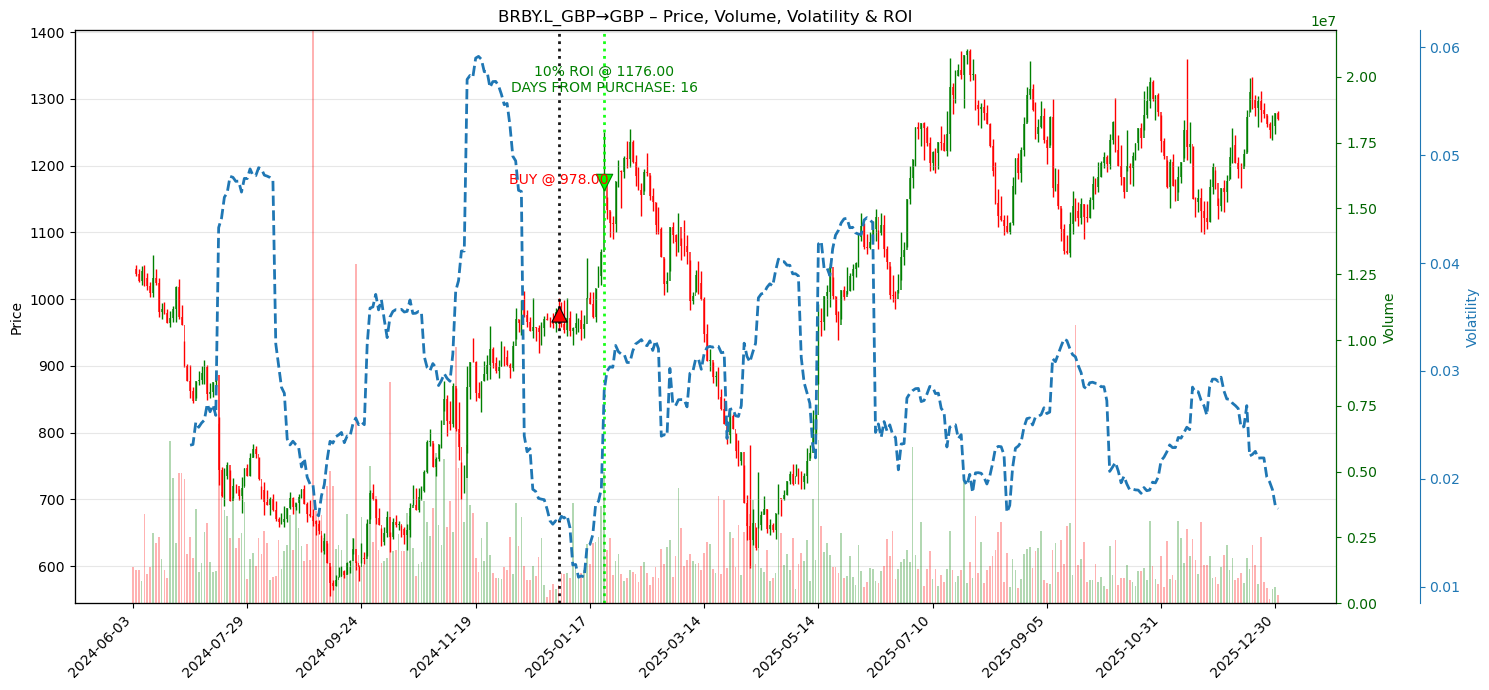

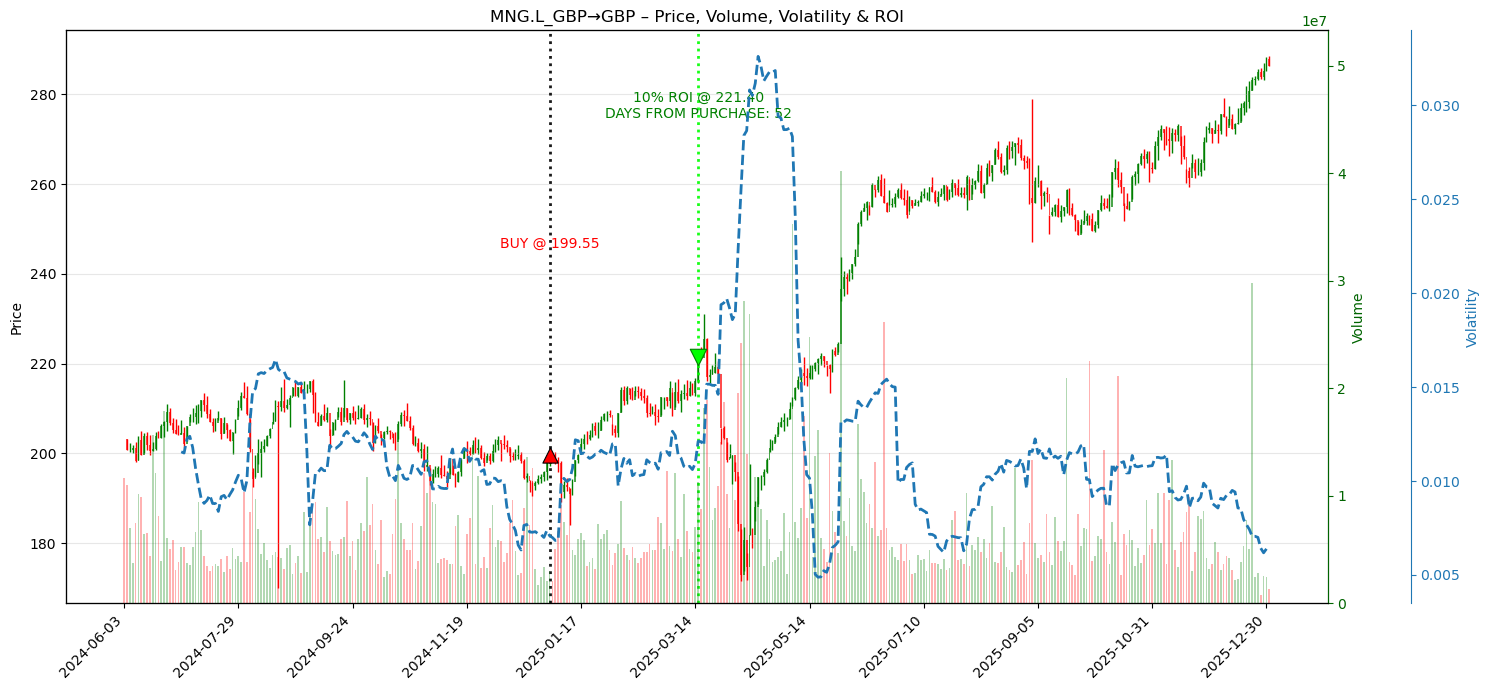

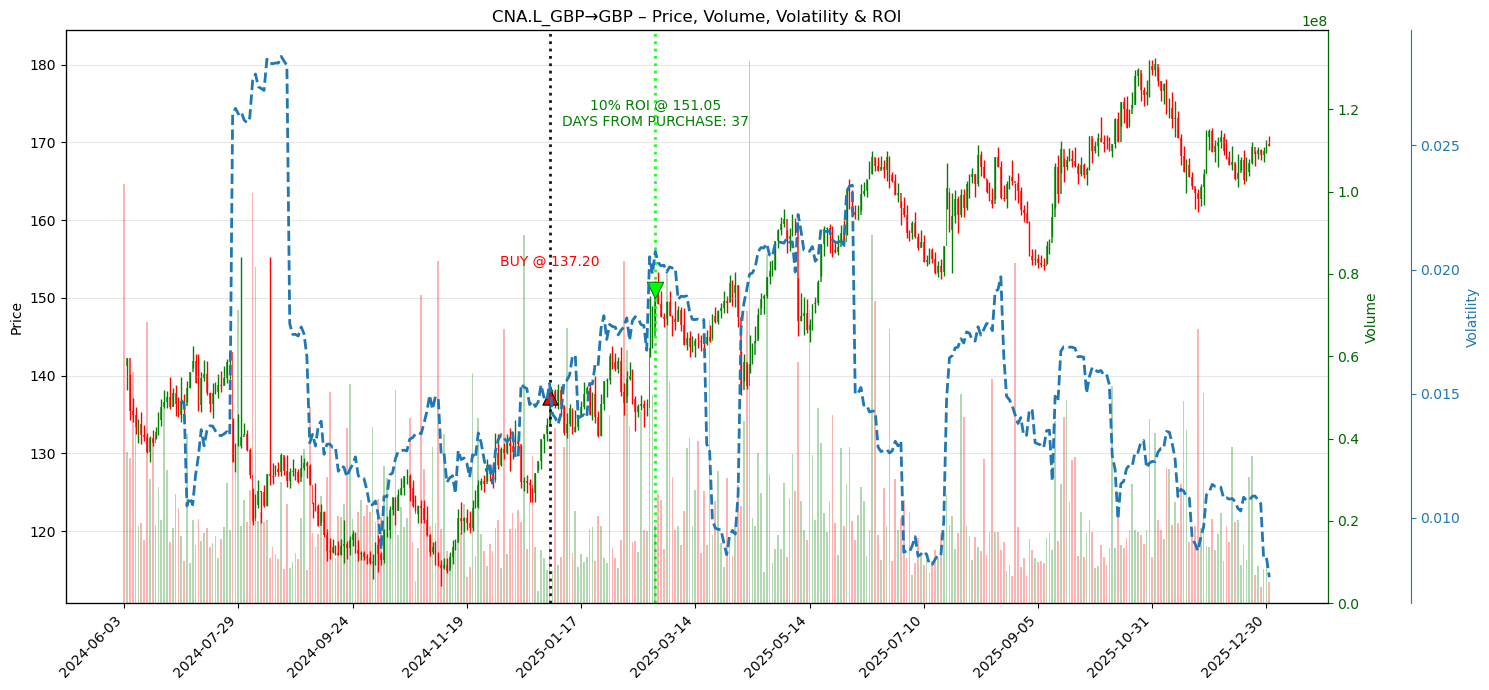

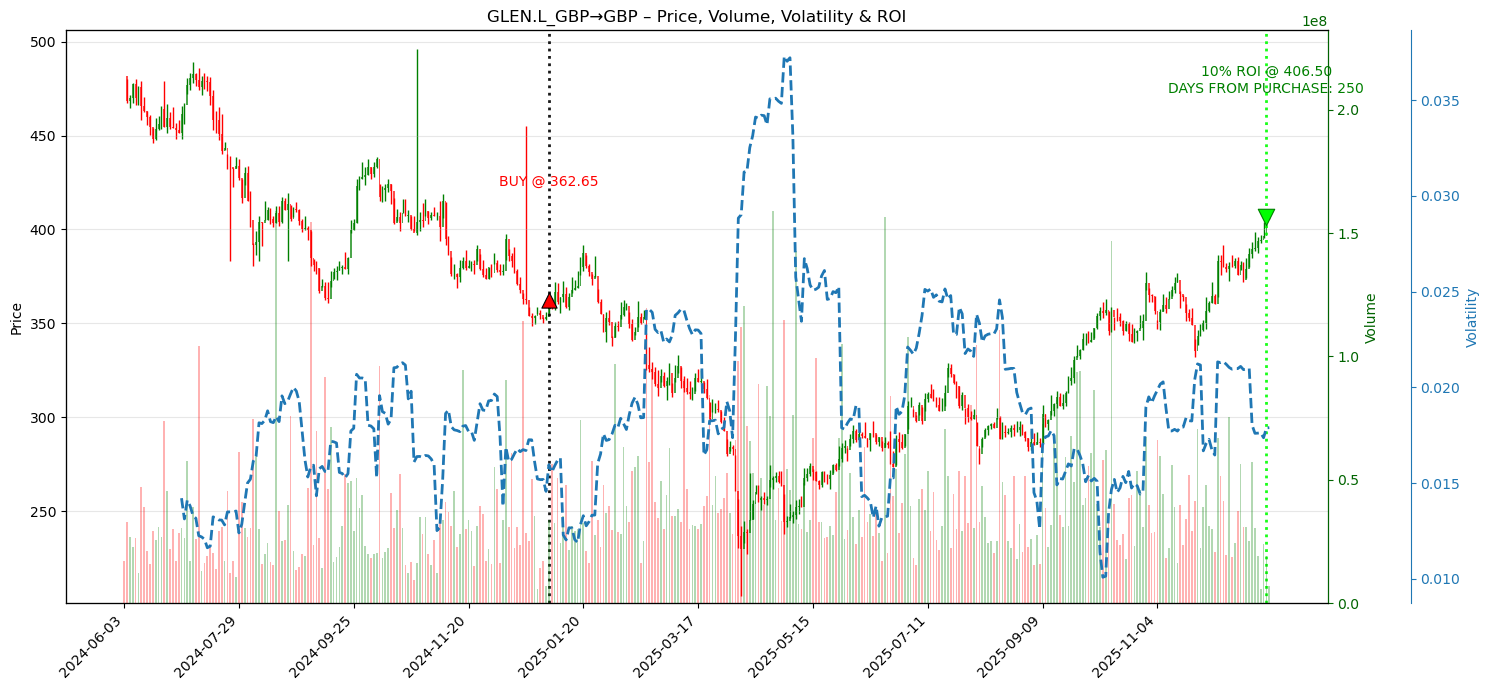

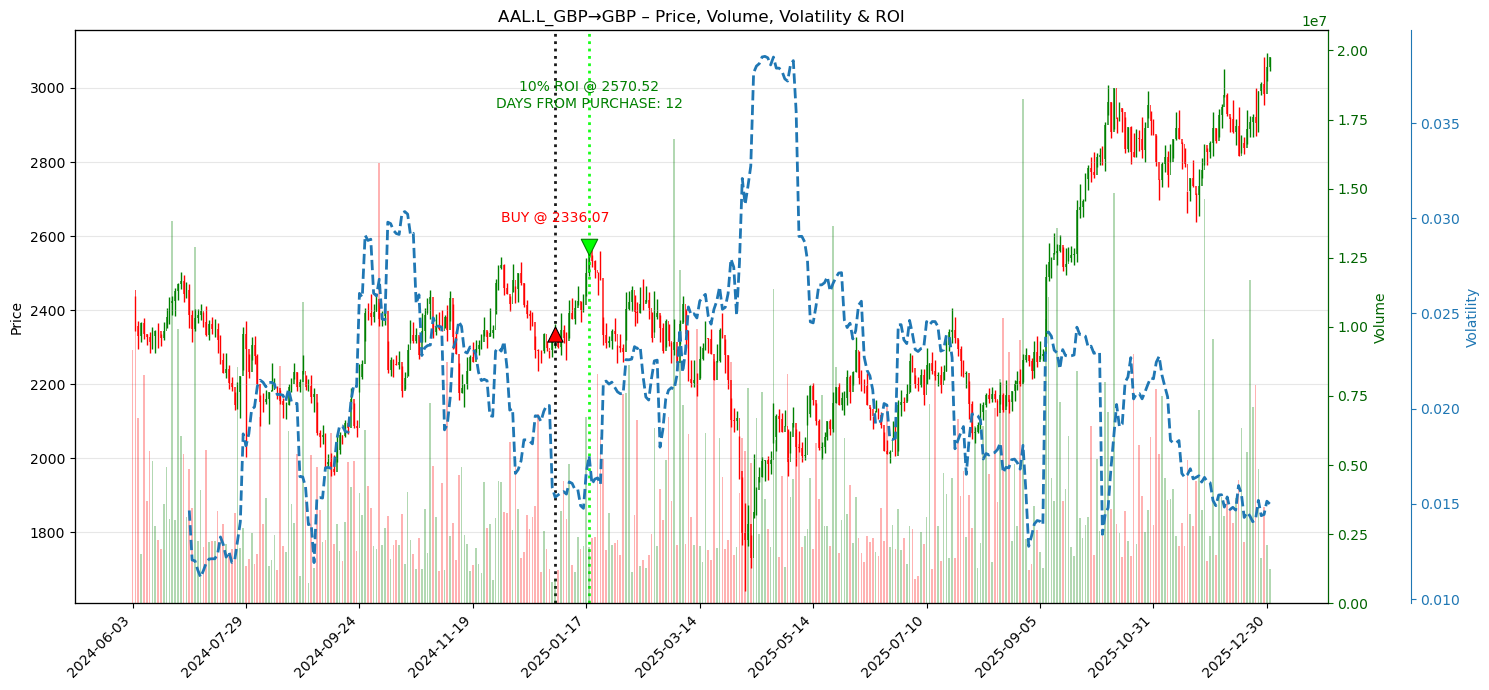

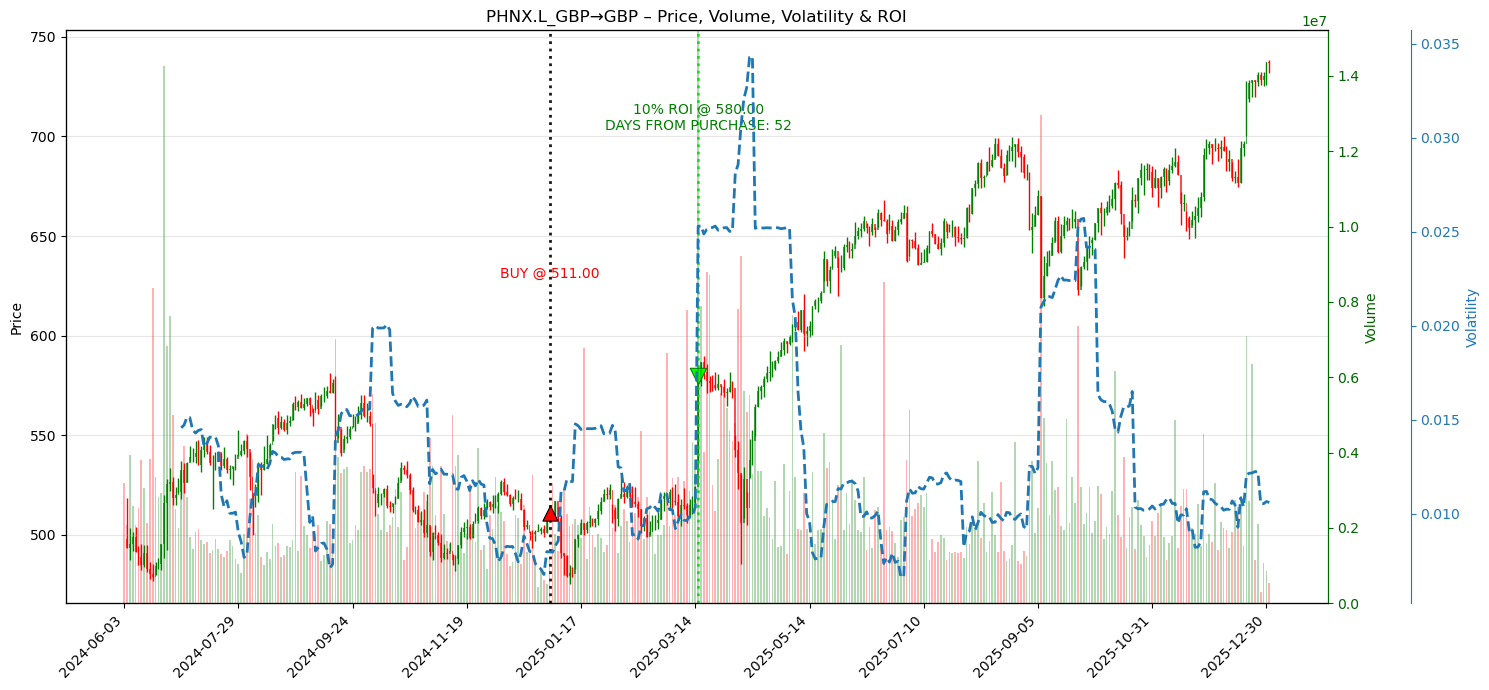

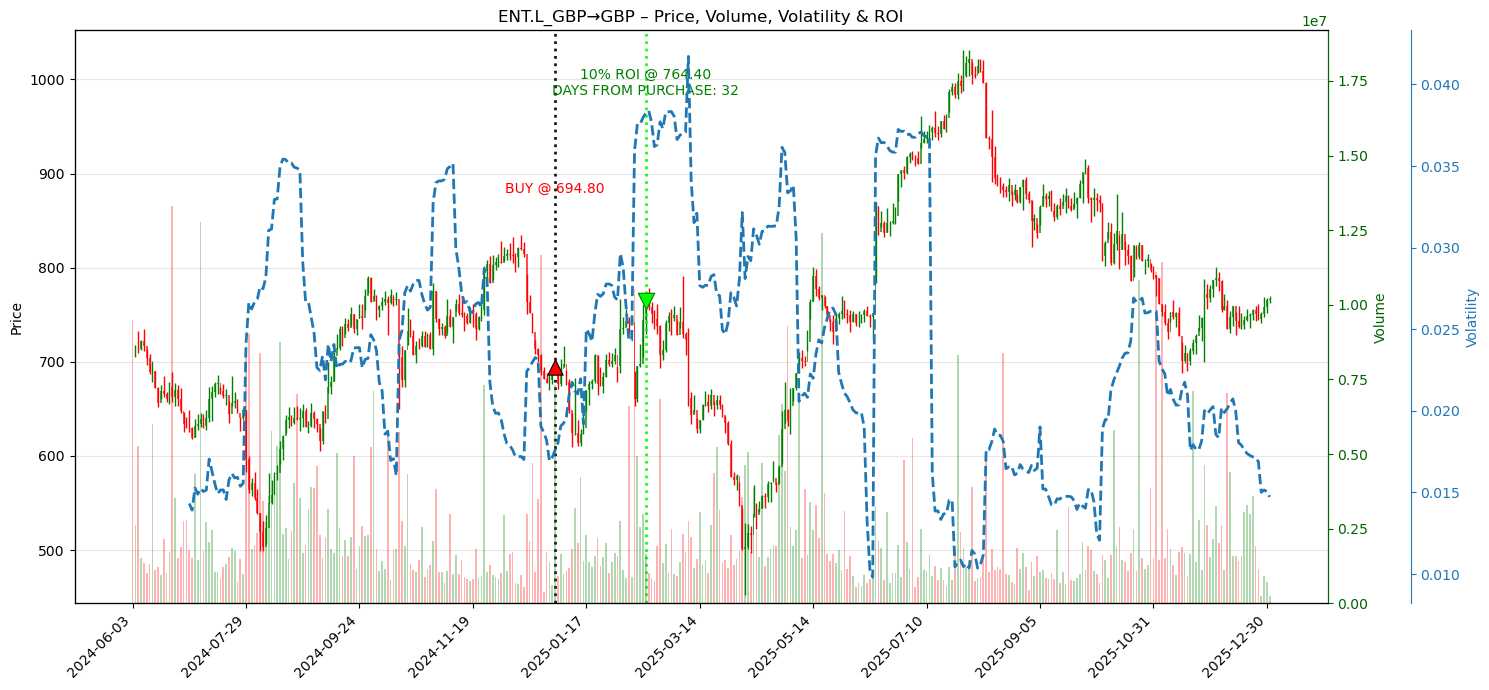

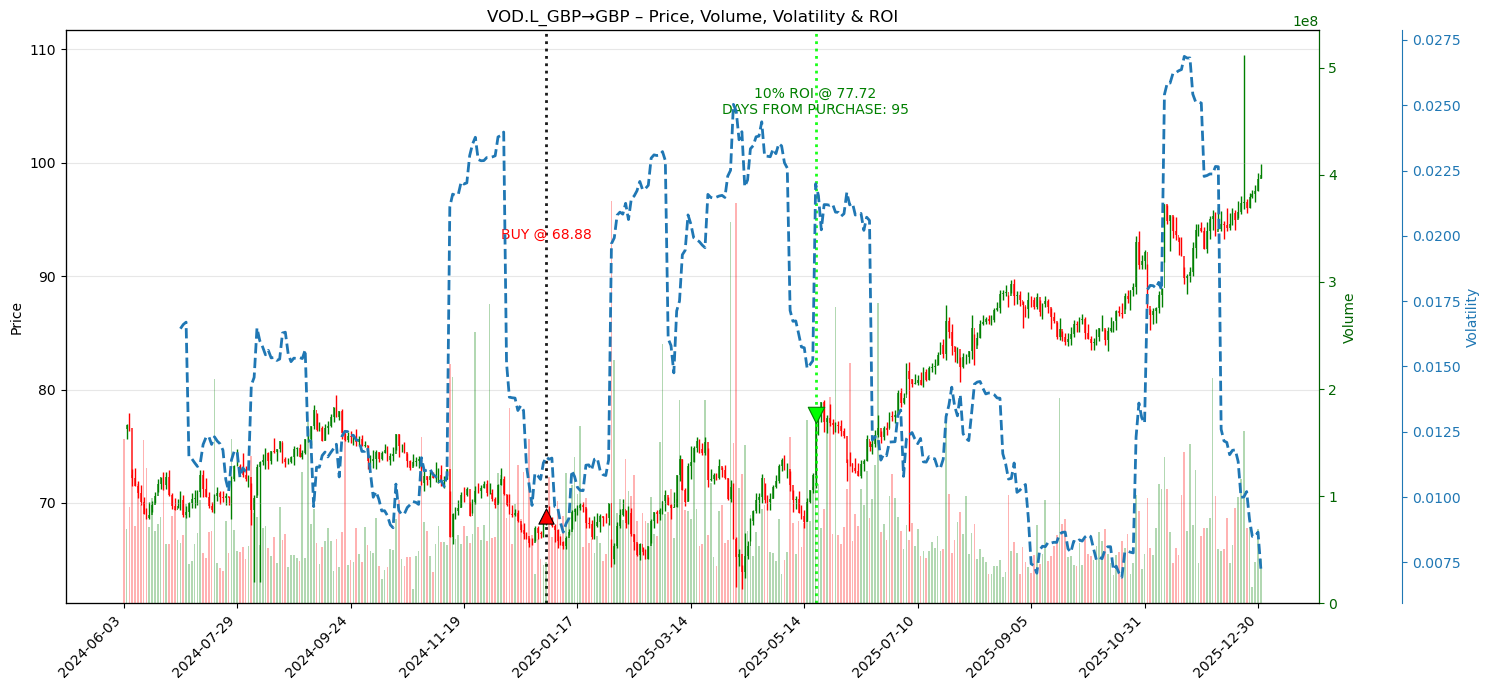

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None plot_candles_volatility_volume_roi succeeded


In [ ]:
ROI(
    df=df_shares_fund,
    actions=undervalued_shares_list,
    # actions=actions_list,
    start=df_shares_fund.index.min(),
    end=df_shares_fund.index.max(),
    purchase_date=purchase_date,
    roi_target=ROI_target
)